Assignment 4 - Socioeconomic analysis
===

*Due: January 17 2023*

You will analyze a set of movies dialogues and calculate their sentiment scores (using Vader, text Blob, or Naive Bayes).

Then you will analyze how the positivity (or negativity) of sentiment score expressed in movie dialogues changes through time and is affected by socioeconomic and historical events.

In particular, you will use the provided R scripts to test how sentiment scores in movies are affected by GDP per capita, Life expectancy and the political cycle (Republican or Democrat president).

## Import

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import nltk
import os

# Download if necessary
try:
    os.path.exists("~/nltk_data/")
except:
    nltk.download("all")

In [3]:
import pandas as pd
import regex as re
import contractions
from textblob import TextBlob
from glob import glob
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy import stats
import numpy as np


lemma = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))
lang = "eng"
data_path = "data/dialogs_preprocessed2/"

## Functions

### Functions for text preprocessing

In [4]:
def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    output = re.sub(r"[^a-zA-Z0-9]", " ", input)
    return output


def clean_tokenization(input):
    output = nltk.word_tokenize(input)
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [p.number_to_words(item)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization(input):
    output = [lemma.lemmatize(word=w, pos="v") for w in input]
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def preprocessing(text, remove_stopwords=True):
    """
    Preprocessing pipeline.
    """
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization(text)
    text = numbers_to_words(text)
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

## Load movie dialogs and preprocess them

In [5]:
df = pd.DataFrame(glob(data_path + "/*.txt"), columns=["movies"])
df["path"] = df["movies"]
df["movies"] = df["movies"].str.replace("^" + data_path, "", regex=True)


df["text"] = df["path"].apply(lambda path: open(path, encoding="utf-8").read())
df["text"] = df["text"].apply(lambda raw_txt: preprocessing(raw_txt))

df.head()

,movies,path,text
0,truegrit_dialog.txt,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...
1,ghost_dialog.txt,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...
2,dropdeadgorgeous_dialog.txt,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...
3,megamind_dialog.txt,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...
4,thisis40_dialog.txt,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...


Add column for movie years

In [6]:
df_years = pd.read_csv("data/movie_years.csv", index_col=0)
df = df.merge(df_years, on="movies")

df.movies = df.movies.str.replace("_dialog.txt$", "", regex=True)

## Add sentiment scores

In [7]:
df["textblob"] = df.text.apply(lambda x: TextBlob(x).sentiment.polarity)

df.head()

,movies,path,text,year,textblob
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...,2010,0.073045
1,ghost,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...,1990,0.089542
2,dropdeadgorgeous,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...,1999,0.147764
3,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...,2010,0.103158
4,thisis40,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...,2012,0.109904


Save dataframe

In [8]:
df.to_csv("data/assignment_4_sentiment_scores.csv", index=False)

Load dataframe

In [9]:
df = pd.read_csv("data/assignment_4_sentiment_scores.csv")

df.head()

,movies,path,text,year,textblob
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,adaptation joel ethan coen base novel charles ...,2010,0.073045
1,ghost,data/dialogs_preprocessed2/ghost_dialog.txt,screenplay bruce joel rubin mess tell breathe ...,1990,0.089542
2,dropdeadgorgeous,data/dialogs_preprocessed2/dropdeadgorgeous_di...,sarah rise know beautiful person sarah rise kn...,1999,0.147764
3,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,write alan schoolcraft brent simons look peace...,2010,0.103158
4,thisis40,data/dialogs_preprocessed2/thisis40_dialog.txt,write judd apatow pete god crazy god incredibl...,2012,0.109904


## Time series

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


df_clean = df.copy().dropna()

reg = linregress(df_clean.year, df_clean.textblob)

print("Regression result:\n")
print("intercept:", reg.intercept)
print("slope:", reg.slope)
print("p:", reg.pvalue)

Regression result:

intercept: 1.2071145932778309
slope: -0.0005662637149927922
p: 0.00031429903489513277


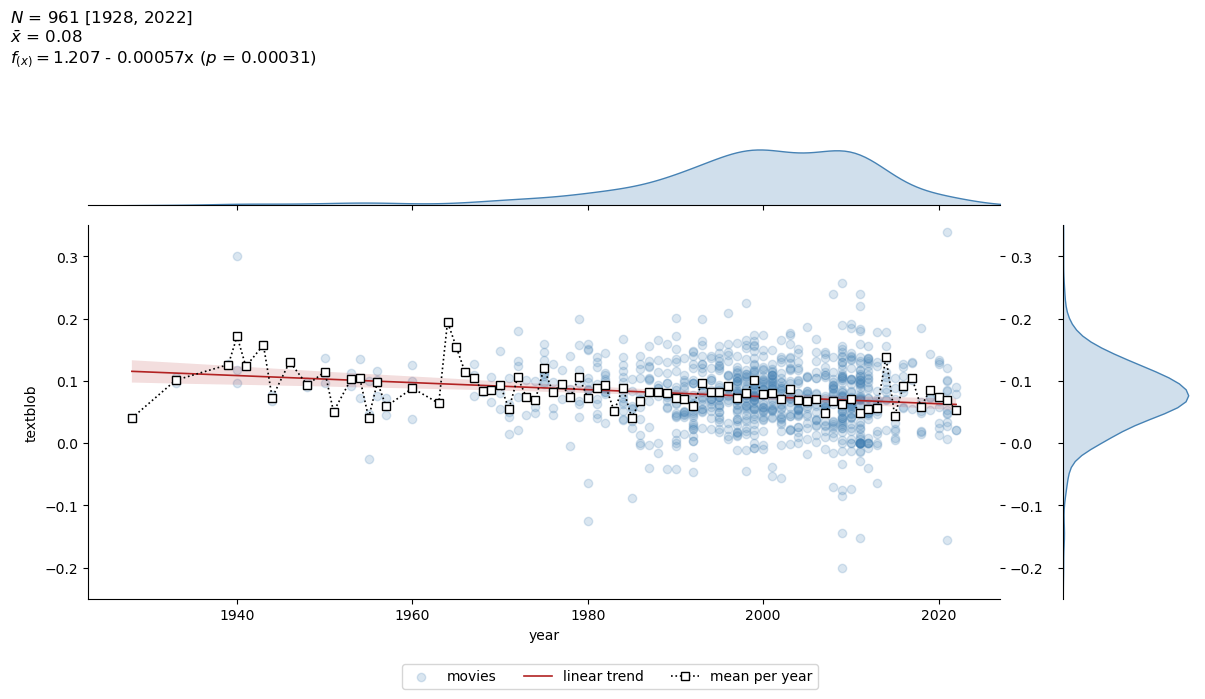

In [11]:
title = (
    f"$N$ = {len(df_clean)} [{min(df_clean.year)}, {max(df_clean.year)}]"
    + "\n"
    + r"$\bar{x}$ = "
    + f"{df_clean.textblob.mean():.2f}"
    + "\n"
    + r"$f_{(x)} = $"
    + f"{reg.intercept:.3f} {'+' if reg.slope > 0 else '-'} {abs(reg.slope):.2g}x"
    + " ($p$ = "
    + f"{reg.pvalue:.2g})"
)

g = sns.JointGrid(
    x=df_clean.year,
    y=df_clean.textblob,
    ylim=(-0.25, 0.35),
    xlim=(-5 + min(df_clean.year), 5 + max(df_clean.year)),
)

regplot = g.plot_joint(
    sns.regplot,
    scatter_kws=dict(alpha=0.2, color="steelblue"),
    line_kws=dict(color="firebrick", lw=1.2, label="linear trend", linestyle="-"),
    label="movies",
)

g.plot_marginals(sns.kdeplot, fill=True, color="steelblue")
# g.ax_marg_y.set_visible(False)

g.fig.figure.set_figheight(6)
g.fig.figure.set_figwidth(12)


lplot = sns.lineplot(
    df_clean.groupby("year").mean()["textblob"],
    lw=1.2,
    linestyle=":",
    marker="s",
    markersize=6,
    markeredgecolor="black",
    color="black",
    markeredgewidth=1,
    markerfacecolor="white",
    ax=g.ax_joint,
    label="mean per year",
    legend=False,
)
g.ax_joint.tick_params(right=True, labelright=True, grid_color="black")
g.fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
g.fig.suptitle(
    title,
    x=0,
    fontsize=12,
    verticalalignment="bottom",
    horizontalalignment="left",
)
g.fig.tight_layout()

<div class="alert alert-info">Significant probably only because of the large number of datapoints. Is the effect actually relevant?</div>

## Influence of socioeconomic and historical events

In particular, you will use the provided R scripts to test how sentiment scores in movies are affected by GDP per capita, Life expectancy and the political cycle (Republican or Democrat president).

In [73]:
df = pd.read_csv("data/2.1_output_frequencies_zscore.csv")
df.head()

,movies,path,text,hope,desire,year,ratio_hope_desire,z_hope,z_desire,z_ratio_hope_desire,z_hope_out,z_desire_out,z_ratio_hope_desire_out,z_ratio_hope_desire2,z_ratio_hope_desire2_out
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,"['adaptation', 'joel', 'ethan', 'coen', 'base'...",0.001336,0.004174,2010,-0.515152,-0.125560,-1.118673,0.872867,-0.125560,-1.118673,0.872867,0.993113,0.993113
1,ghost,data/dialogs_preprocessed2/ghost_dialog.txt,"['screenplay', 'bruce', 'joel', 'rubin', 'mess...",0.000531,0.010350,1990,-0.902439,-0.874456,0.332485,-0.993207,-0.874456,0.332485,-0.993207,-1.206941,-1.206941
2,dropdeadgorgeous,data/dialogs_preprocessed2/dropdeadgorgeous_di...,"['sarah', 'rise', 'know', 'beautiful', 'person...",0.001126,0.007432,1999,-0.736842,-0.320605,-0.353123,-0.195309,-0.320605,-0.353123,-0.195309,0.032518,0.032518
3,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,"['write', 'alan', 'schoolcraft', 'brent', 'sim...",0.001673,0.013859,2010,-0.784615,0.187823,1.156916,-0.425495,0.187823,1.156916,-0.425495,-0.969093,-0.969093
4,thisis40,data/dialogs_preprocessed2/thisis40_dialog.txt,"['write', 'judd', 'apatow', 'pete', 'god', 'cr...",0.001438,0.014019,2012,-0.813953,-0.030638,1.194433,-0.566856,-0.030638,1.194433,-0.566856,-1.225071,-1.225071


### Load socioeconomic data

and filter on United States

In [74]:
df_lifeexp = pd.read_csv("data/life-expectancy.csv").rename(
    columns={"Year": "year", "Life expectancy at birth (historical)": "life_expectancy"}
)
df_lifeexp = df_lifeexp.loc[df_lifeexp.Code == "USA"].reset_index(drop=True)[
    ["year", "life_expectancy"]
]

df_lifeexp.tail()

,year,life_expectancy
118,2017,78.8
119,2018,79.0
120,2019,79.1
121,2020,77.4
122,2021,77.2


In [75]:
df_pres = (
    pd.read_csv("data/US_presidents.csv")
    .rename(columns={"Years (after inauguration)": "year"})[["year", "Party"]]
    .rename(columns={"Party": "president"})
)

df_pres.tail()

,year,president
222,2009,Democrat
223,2010,Democrat
224,2011,Democrat
225,2012,Democrat
226,2013,Democrat


In [76]:
df_gdp = pd.read_csv("data/GDPperCapita_Compact.csv")
df_gdp = (
    df_gdp.loc[df_gdp["country name"] == "United States"]
    .drop(["ccode", "country name"], axis=1)
    .T.reset_index()
    .rename(columns={"index": "year", 156: "GDPpc"})
)
df_gdp.year = df_gdp.year.astype(int)
df_gdp = df_gdp.dropna().reset_index(drop=True)
df_gdp.tail()

,year,GDPpc
215,2012,50394.0
216,2013,50863.0
217,2014,51664.0
218,2015,52591.0
219,2016,53015.0


Keep only rows with no missing values

In [77]:
df_socec = df_gdp.merge(df_pres, on="year", how="inner").merge(
    df_lifeexp, on="year", how="inner"
)

df_socec.tail()

,year,GDPpc,president,life_expectancy
110,2009,48452.9335,Democrat,78.6
111,2010,49266.9159,Democrat,78.8
112,2011,49675.0000,Democrat,78.8
113,2012,50394.0000,Democrat,78.9
114,2013,50863.0000,Democrat,79.0


### Add socioeconomic variable to main dataframe

In [78]:
df = df.merge(df_gdp, on="year", validate="m:1")

### Compute z-score of GPD variable

In [79]:
df["z_GDPpc"] = stats.zscore(df["GDPpc"], nan_policy="omit")
df.head()

,movies,path,text,hope,desire,year,ratio_hope_desire,z_hope,z_desire,z_ratio_hope_desire,z_hope_out,z_desire_out,z_ratio_hope_desire_out,z_ratio_hope_desire2,z_ratio_hope_desire2_out,GDPpc,z_GDPpc
0,truegrit,data/dialogs_preprocessed2/truegrit_dialog.txt,"['adaptation', 'joel', 'ethan', 'coen', 'base'...",0.001336,0.004174,2010,-0.515152,-0.125560,-1.118673,0.872867,-0.125560,-1.118673,0.872867,0.993113,0.993113,49266.9159,0.796092
1,megamind,data/dialogs_preprocessed2/megamind_dialog.txt,"['write', 'alan', 'schoolcraft', 'brent', 'sim...",0.001673,0.013859,2010,-0.784615,0.187823,1.156916,-0.425495,0.187823,1.156916,-0.425495,-0.969093,-0.969093,49266.9159,0.796092
2,shesoutofmyleague,data/dialogs_preprocessed2/shesoutofmyleague_d...,"['write', 'sean', 'anders', 'john', 'morris', ...",0.003330,0.007835,2010,-0.403509,1.729744,-0.258425,1.410798,1.729744,-0.258425,1.410798,1.988169,1.988169,49266.9159,0.796092
3,machete,data/dialogs_preprocessed2/machete_dialog.txt,"['write', 'robert', 'rodriguez', 'officer', 'c...",0.001143,0.010667,2010,-0.806452,-0.305040,0.406817,-0.530709,-0.305040,0.406817,-0.530709,-0.711857,-0.711857,49266.9159,0.796092
4,fighterthe,data/dialogs_preprocessed2/fighterthe_dialog.txt,"['write', 'scott', 'silver', 'paul', 'tamasy',...",NaN,NaN,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49266.9159,0.796092


Save dataframe

In [80]:
df.to_csv("data/3.1_output_complete_dataset.csv", index=False)

Load dataframe

In [81]:
df = pd.read_csv("data/3.1_output_complete_dataset.csv")

### Aggregate by year (mean, count)

In [82]:
df_year = df.groupby("year", as_index=False).mean()
df_year.head()

,year,hope,desire,ratio_hope_desire,z_hope,z_desire,z_ratio_hope_desire,z_hope_out,z_desire_out,z_ratio_hope_desire_out,z_ratio_hope_desire2,z_ratio_hope_desire2_out,GDPpc,z_GDPpc
0,1928,0.001556,0.001361,0.066667,0.079139,-1.779632,3.676253,0.079139,-1.779632,NaN,1.858770,1.858770,11451.069,-3.413128
1,1933,0.001138,0.009134,-0.777778,-0.309699,0.046587,-0.392550,-0.309699,0.046587,-0.392550,-0.356286,-0.356286,8048.225,-3.791893
2,1939,0.002654,0.007699,-0.480952,1.100328,-0.290562,1.037650,1.100328,-0.290562,1.037650,1.390890,1.390890,11171.448,-3.444252
3,1940,0.001314,0.006932,-0.685220,-0.146179,-0.470628,0.053425,-0.146179,-0.470628,0.053425,0.324448,0.324448,12005.095,-3.351460
4,1941,0.002576,0.010710,-0.612245,1.028154,0.417096,0.405041,1.028154,0.417096,0.405041,0.611058,0.611058,13553.402,-3.179121


Add count

In [83]:
df_year_count = df_year.fillna(0).groupby("year", as_index=False).count().iloc[:, :2]
df_year_count.columns = ["year", "text_per_year"]
df_year = df_year.merge(df_year_count, on="year")

Save Dataframe

In [84]:
df_year.to_csv("data/3.2_output_complete_data_by_year.csv", index=False)

Load dataframe

In [85]:
df_year = pd.read_csv("data/3.2_output_complete_data_by_year.csv")

### Add time lags

In [86]:
df_year_lags = df_year.copy()

lag_vars = list(df_gdp.columns)
year = list(df_gdp["year"][1:])
# print(SOC_ECON_data)

## this loop takes each socioeconomic variable
for var in lag_vars:
    var_list = list(df_gdp[var][1:])
    dictionary_var = dict(zip(year, var_list))

    ## and creates the lags within T-20 and T+20
    for lag in range(-20, 21):
        var_lag_list = []

        ## for each row we find what the lagged year would be
        for index1, row in df_year_lags.iterrows():
            yr_df = row["year"] + lag
            # print(yr_df)
            try:
                ##and find what the socioeconomic value was in the lagged year
                var1 = dictionary_var[yr_df]
                var_lag_list += [var1]
            except KeyError:
                var_lag_list += [np.nan]

        # print(GDP_lag_list)
        df_year_lags[var + str(lag)] = var_lag_list

df_year_lags.head()

,year,hope,desire,ratio_hope_desire,z_hope,z_desire,z_ratio_hope_desire,z_hope_out,z_desire_out,z_ratio_hope_desire_out,...,GDPpc11,GDPpc12,GDPpc13,GDPpc14,GDPpc15,GDPpc16,GDPpc17,GDPpc18,GDPpc19,GDPpc20
0,1928,0.001556,0.001361,0.066667,0.079139,-1.779632,3.676253,0.079139,-1.779632,NaN,...,11171.448,12005.095,13553.4020,14869.8610,16050.217,16999.327,16477.552,14822.4665,14311.5472,14734.232
1,1933,0.001138,0.009134,-0.777778,-0.309699,0.046587,-0.392550,-0.309699,0.046587,-0.392550,...,16999.327,16477.552,14822.4665,14311.5472,14734.232,14196.672,15240.000,16125.0000,16444.0000,16917.000
2,1939,0.002654,0.007699,-0.480952,1.100328,-0.290562,1.037650,1.100328,-0.290562,1.037650,...,15240.000,16125.000,16444.0000,16917.0000,16512.000,17370.000,17397.000,17406.0000,16946.0000,17900.000
3,1940,0.001314,0.006932,-0.685220,-0.146179,-0.470628,0.053425,-0.146179,-0.470628,0.053425,...,16125.000,16444.000,16917.0000,16512.0000,17370.000,17397.000,17406.000,16946.0000,17900.0000,18057.000
4,1941,0.002576,0.010710,-0.612245,1.028154,0.417096,0.405041,1.028154,0.417096,0.405041,...,16444.000,16917.000,16512.0000,17370.0000,17397.000,17406.000,16946.000,17900.0000,18057.0000,18175.000


Save Dataframe

In [87]:
df_year_lags.to_csv("data/3.3_output_complete_data_lags.csv", index=False)

Load dataframe

In [88]:
df_year_lags = pd.read_csv("data/3.3_output_complete_data_lags.csv")

<div class="alert alert-warning">From here onwards we will be using the R-scripts?</div>